# Computing galaxy-galaxy-galaxy lensing statistics

In this notebooks we compute the galaxy-galaxy-galaxy lensing (G3L) shear correlation functions on a mock catalog and transform them to the third-order aperture statistics.

In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

## Initialize the catalog instances

For this exercise we use a simplistic mock catalog that traces a euclid-like setup for the n(z) and uses a linear galaxy bias. In order to keep the computation time low, we focus on a single tile and further only look at some tomographic redshift bin combination. 

As we are dealing with two separate catalogs, we need to initialize a `ScalarTracerCatalog` instance for the lenses and a `SpinTracerCatalog` (with `spin=2`) for the sources.

In [2]:
path_to_data = "/vol/euclidraid4/data/lporth/Projects/G3LEstimators/data/GLASS/mocks/euclidlike_fromT17_fullsky/patches/nside8192_real0_patch129.npz"

In [3]:
mock = np.load(path_to_data)

In [4]:
fthin_lens = 2
fthin_source = 1
sel_lens = (mock["zbin"] == 2) * mock["isinner"]
sel_source = (mock["zbin"] == 7) * mock["isinner"]
sources = orpheus.SpinTracerCatalog(spin=2,
                                    pos1=mock["x"][sel_source][::fthin_source], 
                                    pos2=mock["y"][sel_source][::fthin_source],
                                    tracer_1=mock["gam1"][sel_source][::fthin_source],
                                    tracer_2=mock["gam2"][sel_source][::fthin_source], 
                                    weight=None, zbins=None)
lenses = orpheus.ScalarTracerCatalog(pos1=mock["x"][sel_lens][::fthin_lens], 
                                     pos2=mock["y"][sel_lens][::fthin_lens], 
                                     tracer=np.ones_like(mock["x"][sel_lens][::fthin_lens]), 
                                     weight=None, zbins=None)

In [7]:
print("Number of source galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    sources.ngal, sources.ngal/(sources.len1*sources.len2), sources.len1*sources.len2/3600.))
print("Number of lens galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    lenses.ngal, lenses.ngal/(lenses.len1*lenses.len2), lenses.len1*lenses.len2/3600.))

Number of source galaxies:1098203 --> effective nbar: 2.848/arcmin^2 on 107.10 deg^2
Number of lens galaxies:551207 --> effective nbar: 1.431/arcmin^2 on 107.02 deg^2


## Computation of the shear-lens-lens correlation function

For computing the shear-lens-lens correlation function we need to invoke the `GNNCorrelation` class. In principle, it is only required to define a binning for the 3pcf (given by the range of the bins and the number of bins).

**Notes**

* Instead of the number of bins you can also specify the logarithmic bin-width `binsize`. However, the final value of `binsize` might differ slightly from the provided one as we fix the values for the binning range and then choose the largest possible value of `binsize` that is smaller or equal to the input value for `binsize`.

* If no further parameters are passed, the default setup chooses the some accelerations of the discrete multipole estimator renders fairly accurate results for the 3pcf itself and percent-level accuracy for the third-order aperture statistics. In case you want a different setup than the default results you can change the parameters of the parent `BinnedNPCF` class.

In [8]:
min_sep = 0.25
max_sep = 150.
binsize = 0.1
nbinsphi = 256
method = "DoubleTree"
resoshift_leafs=-2
nthreads = 48

gnn = orpheus.GNNCorrelation(min_sep=min_sep, 
                                 max_sep=max_sep, 
                                 binsize=binsize,
                                 nbinsphi=nbinsphi,
                                 method=method,
                                 resoshift_leafs=resoshift_leafs,
                                 nthreads=nthreads,verbosity=2)

In [9]:
%%time
gnn.process(sources, lenses)

Done 99.95 per centCPU times: user 41min 53s, sys: 2.52 s, total: 41min 56s
Wall time: 1min


Once processed, the instance of `GNNCorrelation` contains the multipole components of the shear-lens-lens correlators $\Upsilon^{'}_{\tilde{\mathcal{G}},n}$, as well as their nonrmalizations $\mathcal{W}_n$ in their multipole basis. If required, we can use the `multiples2npcf` method to transform the to the real-space basis, in which they become the more well-known shear-lens-lens correlation function $\tilde{G}$ (Schneider & Watts 2005).

In [10]:
%%time
gnn.multipoles2npcf()

CPU times: user 469 ms, sys: 16 ms, total: 485 ms
Wall time: 483 ms


## Computation of the aperture mass

The integral transormation between the shear-lens-lens 3PCF and their third-order aperture statistics can be done by calling the `GNNNCorrelation.computeNNM` method.

**Notes**

* In case you are only interested in obtaining the third-order aperture statistics, you can also directly call this method right after processing the shape catalog.

* One should only trust the third-order aperture statistics for radii $R\in[\alpha\,\theta_{\rm min}, \beta\,\theta_{\rm max}]$, where $\alpha\approx 5$  and $\beta \approx 0.125$. In the plot below this range is indicated by the dashed vertical lines.

* Furthermore, the binning should be sufficiently fine, i.e. the value of the `GNNCorrelation.binsize` attribute should be less than `0.1` for an accuracy of about one per cent.

In [11]:
%%time
radii_ap = np.geomspace(1.,30.,20)
NNM = gnn.computeNNM(radii_ap)

CPU times: user 9.35 s, sys: 1.66 s, total: 11 s
Wall time: 4.3 s


(1e-08, 8.290079304338584e-05)

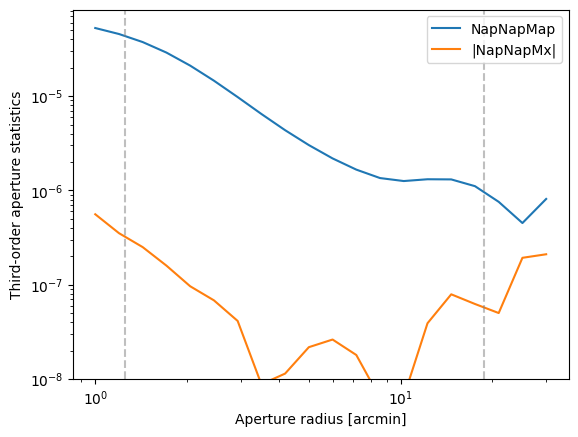

In [12]:
plt.loglog(radii_ap, NNM[0,0].real, label="NapNapMap")
plt.loglog(radii_ap, np.abs(NNM[0,0].imag), label="|NapNapMx|")
plt.axvline(x=5*gnn.min_sep, color="grey",alpha=0.5,ls="--")
plt.axvline(x=0.125*gnn.max_sep, color="grey",alpha=0.5,ls="--")
plt.xlabel("Aperture radius [arcmin]")
plt.ylabel("Third-order aperture statistics")
plt.legend(loc="upper right")
plt.ylim(1e-8,None)

## Computation of the lens-shear-shear correlation function

Let us now repeat the same procedure for the NGG correlation -- the stragegy is practically the same as for GNN. However, we note that due to the multipole structure of $\tilde{G}_+$ we need to choose a fairly large value for `rmin_pixsize` as otherwise the tree-based approximations can produce an artificial $\langle N_{ap}M_{\times}^2 \rangle$ mode.

In [13]:
min_sep = 0.25
max_sep = 150.
binsize = 0.1
nbinsphi = 256
tree_resos = [0.,1.,2.]
rmin_pixsize=40
method = "DoubleTree"
nthreads = 48

ngg = orpheus.NGGCorrelation(min_sep=min_sep, 
                             max_sep=max_sep, 
                             binsize=binsize,
                             nbinsphi=nbinsphi,
                             method=method,
                             rmin_pixsize=rmin_pixsize,
                             tree_resos=tree_resos,
                             nthreads=nthreads,verbosity=2)

In [14]:
%%time
ngg.process(sources, lenses)

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|CPU times: user 1h 39min 9s, sys: 7.94 s, total: 1h 39min 17s
Wall time: 2min 5s


In [15]:
%%time
ngg.multipoles2npcf()

CPU times: user 673 ms, sys: 5 ms, total: 678 ms
Wall time: 675 ms


In [16]:
%%time
radii_ap = np.geomspace(1.,32.,17)
NMM = ngg.computeNMM(radii_ap)

CPU times: user 11.2 s, sys: 11.1 s, total: 22.3 s
Wall time: 3.87 s


/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(1e-09, 4.35571509691883e-06)

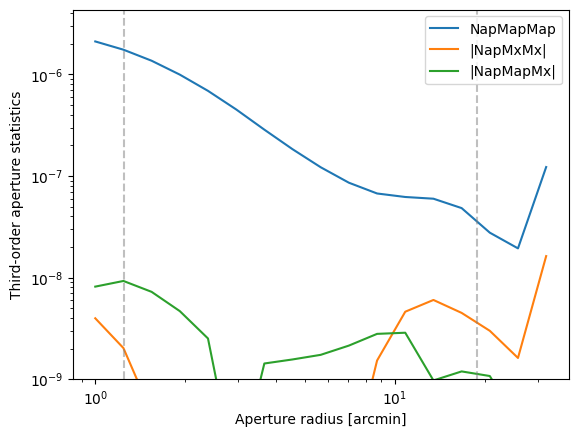

In [19]:
plt.loglog(radii_ap, NMM[0,0], label="NapMapMap")
plt.loglog(radii_ap, np.abs(NMM[1,0]), label="|NapMxMx|")
plt.loglog(radii_ap, np.abs(NMM[2,0]), label="|NapMapMx|")
plt.axvline(x=5*ngg.min_sep, color="grey",alpha=0.5,ls="--")
plt.axvline(x=0.125*ngg.max_sep, color="grey",alpha=0.5,ls="--")
plt.xlabel("Aperture radius [arcmin]")
plt.ylabel("Third-order aperture statistics")
plt.legend(loc="upper right")
plt.ylim(1e-9,None)